In [97]:
%pylab inline
import mcint
import random
import math
import time

from Chempy.parameter import ModelParameters
from Chempy.cem_function import posterior_function_real
a = ModelParameters


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


**NB NOTE THAT THE FUNCTION GIVES LOG POSTERIOR - WE NEED ACTUAL VALUE HERE (unnormalized)** - MUST CHANGE

In [ ]:

# Necessary function returns posterior value - posterior_function_real(param,a)
# Must also check convergence using wider ranges / just using outer ranges

def integrand(x):
    alpha     = x[0]
    logN = x[1]
    logtau = x[2]
    logSFE  = x[3]
    logSFR = x[4]
    xout   = x[5]
    posterior,_ = posterior_function_real((alpha,logN,logtau,logSFE,logSFR,xout),a)
    return posterior

priors = [-2.3,-2.75,-0.8,-0.3,0.55,0.5]
sigma = [0.3,0.3,0.3,0.3,0.1,0.1]
f = 1.5
def sampler():
    while True:
        alpha,logN,logtau,logSFE,logSFR,xout = random.uniform(np.array(priors)-f*np.array(sigma),np.array(priors)+f*np.array(sigma))
        yield (alpha, logN, logtau, logSFE, logSFR, xout)


domainsize = (2.*f)**6.*sigma[0]*sigma[1]*sigma[2]*sigma[3]*sigma[4]*sigma[5] # Streamline this

results = []
errors = []
nval = []
f_sigma = []
start_time = time.time()
for f in [1.,1.5,1.7,1.8,2.0,2.4,2.8,3.]: # NB neural is only trained up to 2-sigma MAX!
    for nmc in [20000]:#[100,200,300,500,1000,2000,5000,10000,20000,50000,100000]:#[1000, 10000, 100000, 1000000, 10000000, 100000000]:
        random.seed(1)
        result, error = mcint.integrate(integrand, sampler(), measure=domainsize, n=nmc)
        results.append(result)
        errors.append(error)
        f_sigma.append(f)
        print("Using f = %f after %.2f seconds" %(f,time.time()-start_time))
        print("Result = %f" %(result))
    


In [ ]:
plt.errorbar(f_sigma,results,errors)
plt.xlim(min(f_sigma)-0.1,max(f_sigma)+0.1)
plt.xlabel('Sigma range used for each parameter')
plt.ylabel('Integrand')
plt.title('mcint output for 20,000 Monte Carlo iterations in 6D space')

In [ ]:
domainsize = ((2.*f)**6.)*sigma[0]*sigma[1]*sigma[2]*sigma[3]*sigma[4]*sigma[5] # Streamline this
print(domainsize)
f

Originally using 2-sigma limits gives 0.939+-0.007 for nmc = 20,000
Reducing range to 1.5-sigma gives **???**

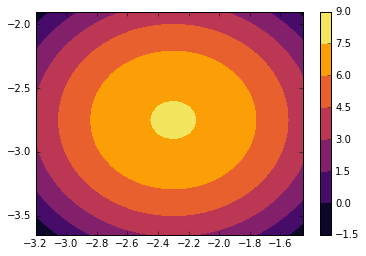

In [113]:
a = ModelParameters()
alpha = np.arange(-3.2,-1.4,0.05)
logN = np.arange(-3.65,-1.85,0.05)
logtau = -0.8
logSFE = -0.3
logSFR = 0.55
xout = 0.5
X,Y=np.meshgrid(alpha,logN,sparse=False)
Z = np.zeros((len(X),len(Y)))
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i,j],_ = posterior_function_real((float(X[i,j]),float(Y[i,j]),logtau,logSFE,logSFR,xout),a)
plt.figure()
plt.contourf(X,Y,Z,cmap='inferno')
plt.colorbar()

In [123]:
out,_ = posterior_function_real((alpha[0],logN[0],logtau,logSFE,logSFR,xout),a)
out

-1.3795011557903698

POSTERIOR FUNCTION SHOULD KEEP SAME SIGN ALWAYS!!

In [124]:
from Chempy.cem_function import extract_parameters_and_priors
p0 = [-2.8,-2.6,-0.9,-0.31,0.56,0.4]
a = extract_parameters_and_priors(p0,a)

In [125]:
prior = np.sum(np.log(a.prior))

In [131]:
from Chempy.neural import neural_output
abundances = neural_output(p0)
sol_dat=np.load('Chempy/input/stars/Proto-sun.npy')	
neural_names = []
for item in a.elements_to_trace:
    if item in list(sol_dat.dtype.names):
        neural_names.append(item)
from Chempy.data_to_test import likelihood_function

In [133]:
likelihood, element_list, model_error, star_error_list, abundance_list, star_abundance_list = \
likelihood_function('proto-sun', abundances, neural_names)

In [134]:
likelihood

4.2628349492372166

In [139]:
from Chempy.data_to_test import likelihood_evaluation
output = likelihood_evaluation(model_error,star_error_list, abundance_list, star_abundance_list)

In [140]:
output

4.2628349492372166

In [142]:
error = np.sqrt(model_error * model_error + star_error_list * star_error_list)
#print(error, 'error')
#print(star_abundance_list, 'star_abundance_list')
#print(abundance_list, 'abundance_list')
list_of_likelihoods = gaussian(star_abundance_list,abundance_list,error)
#print(list_of_likelihoods, 'list_of_likelihoods')
log_likelihood_list = np.log(list_of_likelihoods)
#print(log_likelihood_list, 'log_likelihood_list')
likelihood = np.sum(log_likelihood_list)


NameError: name 'gaussian' is not defined

In [167]:
from scipy.stats import beta,norm
import scipy.integrate as integrate
obs=0.5 # Protosolar observation
mod = 0.4 # Model prediction
sigma_obs = 0.04 # Model error
delta = 0.04 # Model ideal error
def integrand(delta,obs,mod,sigma_obs):
    return beta.pdf(delta,1,3)*norm.pdf(delta,obs-mod,sigma_obs) # For each of 22 dimensions
result = integrate.quad(lambda x: integrand(x,obs,mod,sigma_obs),0,1)

In [160]:
result

(2.415684254352268, 1.489801334164748e-10)

In [24]:
%pylab inline
from scipy.stats import beta,norm
import scipy.integrate as integrate
from Chempy.parameter import ModelParameters

a = ModelParameters()

sol_data = np.load('Chempy/input/stars/Proto-sun.npy')

# REMOVE AGE COLUMN

obs = sol_data[0][:-1]
sigma_obs = sol_data[1][:-1]


Populating the interactive namespace from numpy and matplotlib


/home/philcox/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mod', 'beta', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


IndexError: invalid index

In [22]:
from Chempy.cem_function import posterior_function_returning_predictions
mod,_ = posterior_function_returning_predictions((a.p0,a))


In [23]:
def integrand(delta,obs,mod,sigma_obs):
    return beta.pdf(delta,1,3)*norm.pdf(delta,loc=obs-mod,scale=sigma_obs) # For each of 22 dimensions
result = integrate.quad(lambda x: integrand(x,obs,mod,sigma_obs),0,1)

# Simulate data
#obs = double(np.random.rand(22))
#mod = double(obs+np.random.rand(22)*0.01)
sigma_obs = double(np.random.rand(22)*0.1)
likelihood = double(1)
log10_likelihood = double(0) # To see number better
quadrature_error = double(0) # Error in form sum(delta_x/x)^2
for i in range(22):
    result,error = integrate.quad(lambda x: integrand(x,obs[i],mod[i],sigma_obs[i]),0,1)
    likelihood *= result
    quadrature_error += (error/result)**2
    log10_likelihood += np.log10(result)
error = np.sqrt(quadrature_error)*likelihood
print("Result is %.8f +/- %.8f" %(likelihood,error))

TypeError: invalid type promotion

**Now apply the above to the actual data, with model depending on theta and integrate in 6D** 

In [15]:
prior = a.p0
sigma_prior = [0.3,0.3,0.3,0.3,0.1,0.1]

def integrand(delta,obs,mod,sigma_obs):
    return beta.pdf(delta,1,3)*norm.pdf(delta,loc=obs-mod,scale=sigma_obs) # For each of 22 dimensions
result = integrate.quad(lambda x: integrand(x,obs,mod,sigma_obs),0,1)


def six_integrand(param):
    mod,_ = posterior_function_returning_predictions((param,a))
    likelihood = double(1)
    for i in range(len(mod)):
        result,error = integrate.quad(lambda delta: integrand(delta,obs[i],mod[i],sigma_obs[i]),0,1)
        likelihood *= result
        quadrature_error += (error/result)**2
    error = np.sqrt(quadrature_error)*likelihood
    total_prior = double(1)
    for i in range(len(prior)):
        total_prior *= norm(param[i],loc=prior[i],scale=sigma_prior[i])
    error *= total_prior
    return double(total_prior*likelihood)

TypeError: invalid type promotion

In [14]:
six_integrand(a.p0)

NameError: name 'integrand' is not defined